In [1]:
import os, copy, h5py
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
import numpy as np
import pandas as pd
from syntheticstellarpopconvolve import convolve, default_convolution_config, default_convolution_instruction
from syntheticstellarpopconvolve.general_functions import generate_boilerplate_outputfile, extract_unit_dict, temp_dir
from compas_python_utils.cosmic_integration.ClassCOMPAS import COMPASData
from syntheticstellarpopconvolve.starformation_rate_distributions import starformation_rate_distribution_vanSon2023
from syntheticstellarpopconvolve.metallicity_distributions import metallicity_distribution_vanSon2022
from syntheticstellarpopconvolve.general_functions import calculate_bincenters, calculate_bin_edges
from syntheticstellarpopconvolve.cosmology_utils import lookback_time_to_redshift
from syntheticstellarpopconvolve.SFR_dict_plotting_routines import plot_sfr_dict
import matplotlib.pyplot as plt
from population_vis import get_formation_efficiency
import time
import warnings

Load some compas-specific things as well as efficiencies

1 binary in COMPAS represents 79.11015055714887  solar masses formed
20000000
1582203011.1429775  [Msun]
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
Took 0.19929075241088867 to find efficiencies


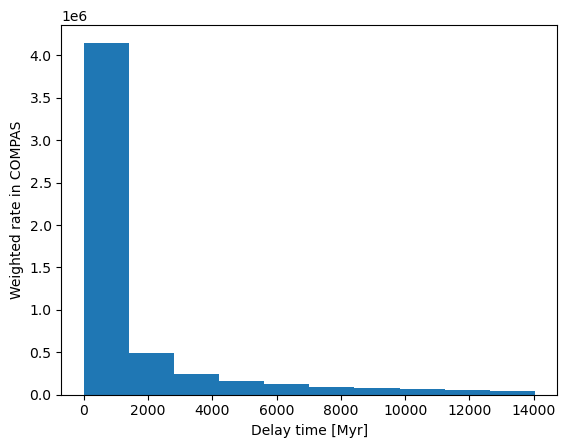

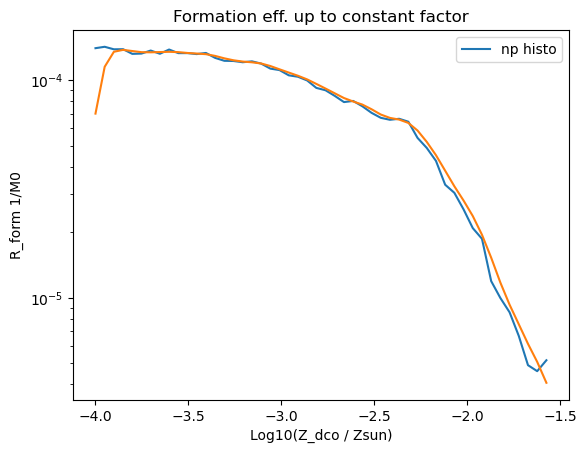

In [2]:
filepath = '/Volumes/Elements/Boesky_sims.h5'
# Create instance of output
output_hdf5_filename = '/Volumes/Elements/sspc_output.h5'#os.path.join(TMP_DIR, "output_example.h5")
generate_boilerplate_outputfile(output_hdf5_filename)

# SET UP DATA -- from a basic dict, port to an h5 file and then store this into the output file
# now we want to use some real data
fdata = h5py.File(filepath)
all_dco_seeds = fdata['BSE_Double_Compact_Objects']['SEED'][()]
all_seeds = fdata['BSE_System_Parameters']['SEED'][()]
metallicities = fdata["BSE_System_Parameters"]["Metallicity@ZAMS(1)"][()]
mixture_weight = fdata["BSE_System_Parameters"]["mixture_weight"][()]
fdata.close()

fe_binned, fe_bins, compasdata = get_formation_efficiency(filepath)
delayTimes = compasdata.delayTimes

# need to get the metallicities as well
dco_query = np.isin(all_seeds, all_dco_seeds[compasdata.DCOmask])
dco_metallicities = metallicities[dco_query]
dco_mixture_weight = mixture_weight[dco_query]
assert len(delayTimes[()]) == len(dco_metallicities), "Something went wrong with masking for dco metallicities"
# to query the probabilties, we can digitize the fe_kde using the dco metallicities
# or just use the kde directly -- TODO: maybe one way is more true than the other?
start_time = time.time()
#dco_efficiencies = fe_kde(dco_metallicities) # this is WAY too slow, have to use bins
dco_efficiencies = fe_binned[np.digitize(np.log10(dco_metallicities), fe_bins) - 1]
print(f'Took {time.time() - start_time} to find efficiencies')

In [3]:
dummy_data = {
        'delay_time': delayTimes[()]*u.Myr,
        'probability': dco_efficiencies,#(10e-4)*np.ones_like(delayTimes[()]),
        'metallicity': np.log10(dco_metallicities) # I wonder if we need to log these as well?
}
dummy_df = pd.DataFrame.from_records(dummy_data) # load as dataframe
dummy_df.to_hdf(output_hdf5_filename, key="input_data/example") # port pandas to hdf

# Set up global configuration
convolution_config = copy.copy(default_convolution_config)
convolution_config["output_filename"] = output_hdf5_filename

# Set up SFR, and hopefully also setup metallicity dependence
num_redshift_bins = 100
redshift_bin_edges = np.linspace(0, 10, num_redshift_bins)
redshift_bin_centers = calculate_bincenters(redshift_bin_edges)
# calculate metallicity distros
num_metallicities = 500
log_metallicity_bin_edges = np.linspace(
    np.log10(np.min(dco_metallicities)),
    np.log10(np.max(dco_metallicities)),
    num_metallicities
)

log_metallicity_bin_centers = calculate_bincenters(log_metallicity_bin_edges)

dpdlogZ = metallicity_distribution_vanSon2022(
    log_metallicity_centers=log_metallicity_bin_centers,
    redshifts=redshift_bin_centers,
)

sfr = starformation_rate_distribution_vanSon2023(redshift_bin_centers).to(u.Msun/u.yr/u.Gpc**3)

high_res_sfr_dict = {
    "redshift_bin_edges": redshift_bin_edges,
    "starformation_rate_array": sfr,
    "metallicity_bin_edges": log_metallicity_bin_edges,
    "metallicity_distribution_array": dpdlogZ,  # We need to transpose!
}

#TODO: assume PLANK13 fit for now
convolution_config['SFR_info'] = {
    'lookback_time_bin_edges': Planck13.lookback_time(redshift_bin_edges),
    'starformation_rate_array': sfr, # this may have incorrect units!
    'metallicity_bin_edges': log_metallicity_bin_edges,
    'metallicity_distribution_array': dpdlogZ
}

# set up convolution bin edges
convolution_config["convolution_lookback_time_bin_edges"] = (
    np.arange(0, 14, 0.25) * u.Gyr
)

# Set up the convolution instructions
convolution_config["convolution_instructions"] = [
    {
        **default_convolution_instruction,
        "input_data_name": "example",
        "output_data_name": "conv_output",
        "data_column_dict": {
            "delay_time": "delay_time",
            "normalized_yield": {"column_name": "probability", "unit": 1/u.Msun},
            'metallicity': 'metallicity'
        }
    }
]

# run convolution
convolve(convolution_config)

lookback: 0.125, sum: 97.54161223592868
lookback: 0.375, sum: 97.54161223592868
lookback: 0.625, sum: 97.54161223592868
lookback: 0.875, sum: 97.54161223592868
lookback: 1.125, sum: 97.54161223592868
lookback: 1.375, sum: 109.92348212727867
lookback: 1.625, sum: 109.92348212727867
lookback: 1.875, sum: 109.92348212727867
lookback: 10.125, sum: 285.06083564002824
lookback: 10.375, sum: 290.9536256875178
lookback: 10.625, sum: 299.23842094367757
lookback: 10.875, sum: 302.2939482461883
lookback: 11.125, sum: 299.6750680357391
lookback: 11.375, sum: 291.321071874785
lookback: 11.625, sum: 269.0591622035202
lookback: 11.875, sum: 238.11674007945078
lookback: 12.125, sum: 191.0116803118501
lookback: 12.375, sum: 125.69665258697952
lookback: 12.625, sum: 72.17121238085252
lookback: 12.875, sum: 31.974569628144994
lookback: 13.125, sum: 8.630493075521017
lookback: 13.375, sum: 0.0
lookback: 13.625, sum: 0.0
lookback: 2.125, sum: 109.92348212727867
lookback: 2.375, sum: 109.92348212727867
look

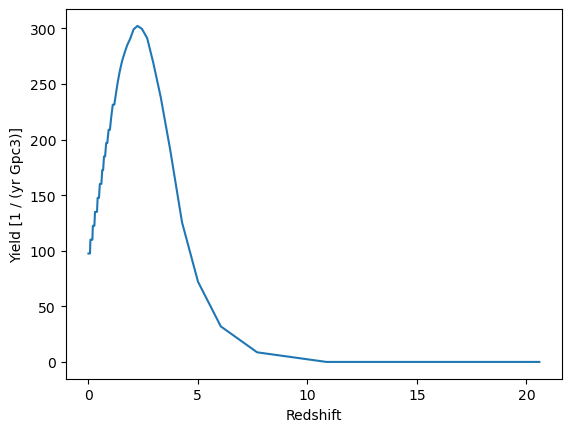

In [ ]:
with h5py.File(
        convolution_config["output_filename"], "r"
    ) as output_hdf5file:
        groupname = "output_data/example/conv_output/convolution_results/"
        # could try and make an actual merger plot. go through each key, sum the values
        yield_locations = output_hdf5file['output_data/example/conv_output/convolution_results/']
        
        merger_ax_lookbacks = []# np.zeros_like(list(yield_locations.keys()))

        merger_fig, merger_ax = plt.subplots(1, 1)
        merger_ax_rates = []
        y_axis_units = u.Unit(extract_unit_dict(output_hdf5file, groupname + list(yield_locations.keys())[0])['yield']).to_string()
        for r, k in enumerate(yield_locations.keys()):
            # get number
            units = u.Quantity(k).unit
            t = u.Quantity(k).value
            if u.Quantity(k) >= u.Quantity('14 Gyr'):
                warnings.warn('Skipping a data point that was older than the universe..')
                break
            merger_ax_lookbacks.append(t)
            merger_ax_rates.append(np.sum(yield_locations[k]['yield'][()]))
            print(f'lookback: {t}, sum: {merger_ax_rates[r]}')
            # maybe we have to reweight the counts
            # yield_in_bin = yield_locations[k]['yield'][()]
            # counts, _ = np.histogram(yield_in_bin, weights=dco_mixture_weight)
            # merger_ax_rates[r] = np.sum(counts)
            # merger_ax[r].hist(
            #     yield_in_bin,
            #     weights=dco_mixture_weight,
            #     density=True
            # )
        # sort these because they don't have to be in order
        # offload to a csv.. something is not right here
        merger_ax_lookbacks = np.array(merger_ax_lookbacks).astype(float) # is this actually look back or just age of universe?
        merger_ax_rates = np.array(merger_ax_rates).astype(float)

        merger_ax_lookbacks = [lookback_time_to_redshift(l, Planck13) for l in merger_ax_lookbacks]
        # dfmerger = pd.DataFrame()
        # dfmerger['times'] = merger_ax_lookbacks
        # dfmerger['rates'] = merger_ax_rates
        # dfmerger.to_csv('./merger_rate.csv')
        
        time_order = np.argsort(merger_ax_lookbacks)
        import matplotlib.ticker as mticker

        # merger_ax.set_ylim(np.min(merger_ax_rates), np.max(merger_ax_rates))
        merger_ax.yaxis.set_inverted(False)  # ensure not inverted

        # restore auto ticks/labels
        merger_ax.yaxis.set_major_locator(mticker.AutoLocator()) #from GPT. something was wrong with matplotlib
        merger_ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

        merger_ax.plot(
            np.round(merger_ax_lookbacks,2)[time_order], #TODO: make unit more robust
            merger_ax_rates[time_order]
        )
        merger_ax.set_xlabel('Redshift')
        # merger_ax.set_ylim(sorted(merger_ax.get_ylim()))
        # merger_ax.set_yscale('log')
        
        merger_ax.set_ylabel(f'Yield [{y_axis_units}]')
        merger_fig.savefig('merger rates.png')

# axis_dict = plot_sfr_dict(
# high_res_sfr_dict,
# time_type="redshift",
# metallicity_string="logZ",
# metallicity_distribution_multiply_by_metallicity_bin_sizes=False,
# metallicity_distribution_multiply_by_sfr=False,
# metallicity_distribution_scale="log10",
# metallicity_distribution_cmap=copy.copy(plt.cm.viridis),
# return_axis_dict=True,
# figsize=(8,8),
# fontsize=12,
# )
# axis_dict['fig'].savefig('./sfr.png')